In [171]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout, GRU, Reshape
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [172]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7233605068192654220
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2909221684
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3424945748119248814
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [173]:
X_train = np.load('training_data\specs_train_processed.npy')
print(f"before: {X_train.shape}")
X_train = np.swapaxes(X_train,2,1)
print(f"after: {X_train.shape}")
X_train = np.expand_dims(X_train,3)
print(f"final: {X_train.shape}")
y_train = np.load('training_data\labels_train_processed.npy')

before: (7983, 100, 130)
after: (7983, 130, 100)
final: (7983, 130, 100, 1)


In [174]:
X_train.shape[1:]

(130, 100, 1)

In [175]:
from keras import Model
from keras.layers import Input, Dense, concatenate
N_CLASSES = 10
a_input = Input(shape = X_train.shape[1:])
print(a_input.shape)
#1
a = Conv2D(filters=16, kernel_size=(3,3), input_shape=X_train.shape[1:])(a_input)
a = MaxPool2D(pool_size=(2,2))(a)
a = BatchNormalization()(a)
print(a.shape)
#2
a = Conv2D(filters=32, kernel_size=(3,3))(a)
a = (MaxPool2D(pool_size=(2,2)))(a)
a = (BatchNormalization())(a)
print(a.shape)
#3
a=(Conv2D(filters=64, kernel_size=(3,3)))(a)
a=(MaxPool2D(pool_size=(2,2)))(a)
a=(BatchNormalization())(a)
print(a.shape)
#4
a=(Conv2D(filters=128, kernel_size=(3,1)))(a)
a=(MaxPool2D(pool_size=(2,2)))(a)
a=(BatchNormalization())(a)
print(a.shape)
#5
a=(Conv2D(filters=128, kernel_size=(3,3)))(a)
a=(MaxPool2D(pool_size=(2,3)))(a)
a=(BatchNormalization())(a)
print(a.shape)
a = (Reshape((256,)))(a)
# Recurrent Layer
a = Model(inputs=a_input, outputs=a)


(None, 130, 100, 1)
(None, 64, 49, 16)
(None, 31, 23, 32)
(None, 14, 10, 64)
(None, 6, 5, 128)
(None, 2, 1, 128)


In [176]:
from keras.layers import Embedding, Bidirectional,LSTM
print(a_input.shape)
# b = (MaxPool2D(pool_size=(2,1),strides = (2,1)))(a_input)
# print(b.shape)
b = (Reshape((130,100)))(a_input)
b = (GRU(256))(b)
b = Model(inputs=a_input, outputs=b)

(None, 130, 100, 1)


In [177]:
mixed = concatenate([a.output,b.output])
z = Dense(N_CLASSES,activation='softmax')(mixed)
# Output Layer

In [178]:
model = Model(inputs=a.input, outputs=z)

In [179]:
# N_CLASSES = 10
# model = Sequential(name="gtzan_crnn")

# # Convolutional Block 1
# model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=X_train.shape[1:])) # X_train holds the processed training spectrograms
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())

# # Convolutional Block 2
# model.add(Conv2D(filters=32, kernel_size=(3,3)))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())

# # Convolutional Block 3
# model.add(Conv2D(filters=64, kernel_size=(3,3)))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())

# # Convolutional Block 4
# model.add(Conv2D(filters=128, kernel_size=(3,3)))
# model.add(MaxPool2D(pool_size=(1,5)))
# model.add(BatchNormalization())

# # Reshape Layer (effectively squeezes the frequency dimension away)
# model.add(Reshape((12,128)))
# # Recurrent Layer
# model.add(GRU(256, return_sequences=False, activation="tanh"))

# # Dense Layer
# model.add(Dense(64))
# model.add(Dropout(0.4))

# # Output Layer
# model.add(Dense(N_CLASSES, activation="softmax"))

In [180]:
x_valid = np.load('training_data\specs_val_processed.npy')
x_valid = np.swapaxes(x_valid,2,1)
x_valid = np.expand_dims(x_valid,3)
y_valid = np.load('training_data\labels_val_processed.npy')

In [181]:
features = pd.read_csv("features_final.csv")
features_valid = pd.read_csv("features_valid.csv")
features_test = pd.read_csv("features_test.csv")
features = features.drop('Unnamed: 0',axis=1)
features_test = features_test.drop('Unnamed: 0',axis=1)
features_valid = features_valid.drop('Unnamed: 0',axis=1)

In [182]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [183]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
              loss = keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.fit(x= X_train, y=y_train, epochs = 25, validation_data = (x_valid, y_valid), batch_size=64)

Epoch 1/25
125/125 [==============================] - 14s 65ms/step - loss: 1.3703 - accuracy: 0.5365 - val_loss: 3.3010 - val_accuracy: 0.1872
Epoch 2/25
 85/125 [===================>..........] - ETA: 2s - loss: 0.9450 - accuracy: 0.6857

KeyboardInterrupt: 

In [ ]:
x_test = np.load('training_data\specs_test_processed.npy')
x_test = np.swapaxes(x_test,2,1)
x_test = np.expand_dims(x_test,3)
y_test = np.load('training_data\labels_test_processed.npy')

In [ ]:
model.evaluate(x=x_test, y=y_test)

32/32 [==============================] - 1s 21ms/step - loss: 1.6563 - accuracy: 0.6574


[1.6563279628753662, 0.6574257612228394]

## Confusion Matrix

In [ ]:
genres = {
 0:'blues',
 1:'classical',
 2:'country',
 3:'disco',
 4:'hiphop',
 5:'jazz',
 6:'metal',
 7:'pop',
 8:'reggae',
 9:'rock'
}

32/32 [==============================] - 2s 21ms/step


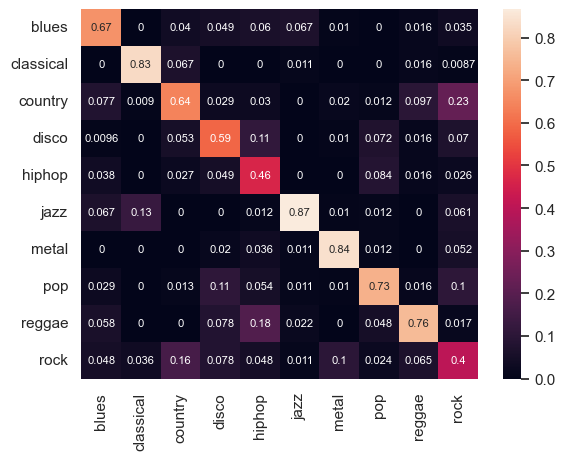

In [ ]:

y_prediction = model.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)
result = confusion_matrix(y_test, y_prediction , normalize='pred')

df_cm = pd.DataFrame(result, (genres.values()), (genres.values()))
#plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}) # font size

plt.show()

In [ ]:
data.shape

NameError: name 'data' is not defined